In [346]:
#Python 3.11.2
#Import packages
# import pandas as pd
# import numpy as np
# import pylab as pl
# import random
# import matplotlib.pyplot as plt
# from collections import defaultdict
# import json # for pretty printing
# import geopandas as gpd
# import os
from funct_process_data import *  # Import all functions from funct_process_data.py

We have three different data sources. 

1. The data collected by Bodil corresponds to the plague period.
2. The information from the TABVERK database includes the population size for parishes in the posterior years of the plague.
3. The geographical information (polygons) for some parishes. This information doesn't correspond to the plague period.

Our goal is to create a unique database for our project: Plague spread across Scania, Sweden, from 1710 to 1715.

1. We start working with Bodil's information which we store in two databases: One database corresponds to the parishes affected by the plague, the region where parishes are located in Scania, the beginning and end of the outbreaks, and the number of victims. The second database corresponds to all the parishes in Scania during the plague period, the district, and the region they belonged to.

The goal is to merge these two databases. First we set the working directory for private and public files.

In [227]:
# For public files paths
data_folder = "data"
appendix6_path = os.path.join(data_folder, "Appendix6Bodil.csv")

# For private files paths
data_private_folder = "data/private"
allParishes_path = os.path.join(data_private_folder, "allParishesScania.xlsx")

Reading the different data sources (.xlsx, and .csv files)

In [228]:
# Bodil's data Appendix 6 plague parishes
plagueParishesScania = pd.read_csv(appendix6_path, sep=",", encoding="utf-8")
# All parishes in Scania during the plague period
allParishesScania = pd.read_excel(allParishes_path)

Transforming the lowercase to uppercase and checking the type

In [229]:
allParishesScania = allParishesScania.apply(
    lambda x: x.astype(str).str.upper())
plagueParishesScania = plagueParishesScania.apply(
    lambda x: x.astype(str).str.upper())
type(plagueParishesScania)
type(allParishesScania)

pandas.core.frame.DataFrame

Visualizing the DataFrames and calculating the length of each one.

In [230]:
print(len(allParishesScania))
plagueParishesScania.head(3)

398


,BeginPlaguePeriod,EndPlaguePeriod,ParishName,VictimsNumber,Region
0,NOV 1710,APR 1711,NÄSUM,671,NORTHEAST
1,FEB 1712,UNDEFINED,NÄSUM,?,NORTHEAST
2,NOV 1710,AUG 1711,IVÖ,123,NORTHEAST


In [231]:
print(len(plagueParishesScania))
allParishesScania.head(3)

178


,Region,District(Härad),ParishName
0,SOUTHEAST,ALBO,ANDRARUM
1,SOUTHEAST,ALBO,BRÖSARP
2,SOUTHEAST,ALBO,ELJARÖD


Merging the two datasets (allParishesScania and plagueParishesScania)

In [232]:
parishesScania = pd.merge(
    allParishesScania, plagueParishesScania, how='left', on=['ParishName', 'Region'])

Checking that the new data frame keep all the outbreaks for parish

In [233]:
parishesScania.loc[parishesScania['ParishName'] == 'NÄSUM']

,Region,District(Härad),ParishName,BeginPlaguePeriod,EndPlaguePeriod,VictimsNumber
393,NORTHEAST,VILLANDS,NÄSUM,NOV 1710,APR 1711,671
394,NORTHEAST,VILLANDS,NÄSUM,FEB 1712,UNDEFINED,?


Extracting the parishes' names from the data frame

In [234]:
parishesScania_names = get_Names(parishesScania, 'ParishName').unique().tolist()
len(parishesScania_names)

397

The length of 'parishesScania_names' is less than the number of rows in the data frame 'allparishesScania'. This means, there is a repeated name: 'LÖDDEKÖPINGE'. We have to check the information for this parish:

In [235]:
parishesScania.loc[parishesScania['ParishName'] == 'LÖDDEKÖPINGE']

,Region,District(Härad),ParishName,BeginPlaguePeriod,EndPlaguePeriod,VictimsNumber
87,SOUTHWEST,HARJAGER,LÖDDEKÖPINGE,AUG 1712,DEC 1712,?
161,SOUTHWEST,TORNA,LÖDDEKÖPINGE,AUG 1712,DEC 1712,?


Only the parish LÖDDEKÖPINGE at HARJAGER was affected by the plague according to the file 'Bilaga 6 d - sydväst.doc' provided by Bodil. So we need to fix the information in the other row (161).

In [236]:
parishesScania.at[161, 'BeginPlaguePeriod'] = np.NaN
parishesScania.at[161, 'EndPlaguePeriod'] = np.NaN
parishesScania.at[161, 'VictimsNumber'] = np.NaN

Checking the data:

In [237]:
parishesScania.loc[parishesScania['ParishName'] == 'LÖDDEKÖPINGE']

,Region,District(Härad),ParishName,BeginPlaguePeriod,EndPlaguePeriod,VictimsNumber
87,SOUTHWEST,HARJAGER,LÖDDEKÖPINGE,AUG 1712,DEC 1712,?
161,SOUTHWEST,TORNA,LÖDDEKÖPINGE,NaN,NaN,NaN


Filtering the data frame by region and then get the names of the parishes:

In [375]:
southeastParishes = parishesScania.loc[parishesScania['Region'] == 'SOUTHEAST']
southeastParishes_names = get_Names(southeastParishes, 'ParishName')

,Region,District(Härad),ParishName,BeginPlaguePeriod,EndPlaguePeriod,VictimsNumber
0,SOUTHEAST,ALBO,ANDRARUM,NaN,NaN,NaN
1,SOUTHEAST,ALBO,BRÖSARP,NaN,NaN,NaN
2,SOUTHEAST,ALBO,ELJARÖD,JAN 1713,UNDEFINED,3
3,SOUTHEAST,ALBO,FÅGELTOFTA,NaN,NaN,NaN
4,SOUTHEAST,ALBO,RAVLUNDA,NaN,NaN,NaN
...,...,...,...,...,...,...
58,SOUTHEAST,LJUNITS,SKÅRBY,AUG 1712,DEC 1712,70
59,SOUTHEAST,LJUNITS,SKÖRUP,NaN,NaN,NaN
60,SOUTHEAST,LJUNITS,SNÅRESTAD,AUG 1712,AUG 1713,38
61,SOUTHEAST,LJUNITS,VILLIE,AUG 1712,AUG 1712,?


2. We will process the census file to get the population size by parish. This file corresponds to all of Sweden, so we process it to keep only the information for Scania for the closest year to the plague outbreaks. We start setting the directory and reading the census file:

In [342]:
# Set the working directory for private files
data_private_folder = "data/private"
census_path = os.path.join(data_private_folder, 'FILE01_FALD.csv')
censusSweden = pd.read_csv(census_path, sep=';')
censusSweden.shape

(102360, 50)

Checking the memory usage (this is not necessary)

In [ ]:
censusSweden.info(memory_usage='deep')

Checking the names of all columns in the data

In [241]:
columns = censusSweden.columns

Calling the data only with specific columns to reduce the memory usage.

In [343]:
censusSweden = pd.read_csv(census_path, sep=';', usecols=[
                           'LANGENNMN'  # Standard name of the county for the geographical area in plain text
                           , 'GEOIDNMN'  # Standard name of the geographical area in plain text, i.e. not a source name
                           , 'GEOIDTYP'  # Type of breakdown of the geographical area  0 =Assembly, 1 = Pastorate, 2 = Other type, 3 = Several parishes, 9 = Part of a parish
                           , 'AR'  # Year
                           , 'KON'  # 1 = Man  2 = Female. I choose 1 but it could be 2 for the total population
                           , 'BEF_TOT'  # Total population at source
                           , 'BEF_GENTOT'  # Total population, generated
                           ])

Processing the census data such that corresponds only to Scania.

In [344]:
censusScania = censusSweden.loc[((censusSweden['LANGENNMN'] == 'KRISTIANSTADS LÄN') | (
    censusSweden['LANGENNMN'] == 'MALMÖHUS LÄN')) & (censusSweden['KON'] == 1)]
censusScania.shape

(8748, 7)

Cleaning the data: Now, we remove given strings and white spaces at the end of a word. To do so, we must provide the string list to delete. In this step, you can use regular expressions.

In [347]:
# Regex to delete the following strings:
# ', DEL (KRISTIANSTAD)', ', DEL (MALMÖHUS)', ', DEL (MALMÖHUS LÄN)'
# ,', DEL AV (FROSTA HÄRAD, MALMÖHUS LÄN)', ', DEL (EVERÖD, MALMÖHUS)'
# ,' DEL (HYLLINGE, MALMÖHUS)', ' (MALMÖ SF)', '(STAFFANSTORP)'
# ,' GARNISONSFÖRS.', ' OCH GARNISONSFÖRS.', ' STADS', ' STAD'

regex = r'(,?\s+DEL\s(AV\s)?\((\w+,?\s?)+\))|(\s*\((\w+,?\s?)+\))|(\s+(OCH\s)?GARNISONSFÖRS\.?)|(\s+STADS?)'
censusScania = replace_strings_and_regex(censusScania, 'GEOIDNMN', [
    'PASTORAT', 'HOSPITAL', ' LANDS', ' SLOTTSFÖRSAMLING', ' DOMKYRKOFÖRSAMLING', regex
])
censusScania.shape


(8748, 7)

Process the data from Scania only to keep the first population size registered for each parish.
This was done following two approaches. 

1. First approach: We group the data by parish name and then select the minimum year. As the minimum year is not unique after deleted strings, this approach allows repetitions.

In [ ]:
popSizeScania_rep = process_dataframe_rep(censusScania, 'GEOIDNMN', 'AR')
print(popSizeScania_rep.shape)
popSizeScania_rep.groupby(['GEOIDNMN']).get_group('HELSINGBORGS')

2. Second approach: This method explores the given DataFrame exhaustively and keeps the required information in a dictionary. In our case, this information corresponds to the position associated with each parish name and the minimum year, according to the original DataFrame. This approach doesn't allow repetitions since the condition for replacing the information in the dictionary is strict (<).

In [ ]:
popSizeScania = process_dataframe(censusScania, 'GEOIDNMN', 'AR')
print(popSizeScania.shape)
popSizeScania.groupby(['GEOIDNMN']).get_group('HELSINGBORGS')

3. The geographical information for Scania is already projected on the plane, i.e. the measures are in meters not in longitude and latitude. To process the shape file, we proceed as with the census file. First, we set the directory and chose the columns to work with.

In [394]:
# Get the current working directory
data_folder = "MapScaniaSweden"
parishScania_path = os.path.join(data_folder, "Parishes1720_1890.shp")
SkaneMap_path = os.path.join(data_folder, "Skane1720-1890.shp")

SkaneMap = gpd.read_file(SkaneMap_path)
parishScaniaMap = gpd.read_file(parishScania_path)
selected_columns = ['G_NAME','GET_END_YE', 'geometry']
SkaneMap = SkaneMap[selected_columns]
parishScaniaMap = parishScaniaMap[selected_columns]

Now, we remove white spaces and patterns. Then, we filter the shape file considering the column "GET_END_YE" of the polygon.

In [351]:
parishScaniaMap = replace_strings_and_regex(parishScaniaMap, 'G_NAME', ['FÖRSAMLING'
                                                                        , 'L LÄN'
                                                                        , 'S LÄN'
                                                                        , 'M LÄN'
                                                                        , 'HELIGA TREFALDIGHETS'
                                                                        , ' LANDSFÖRSAMLING'
                                                                        , ' STADS'
                                                                        , ' LANDS'
                                                                        , 'SKÅNES'
                                                                        ])
parishScaniaMap = process_dataframe(parishScaniaMap, 'G_NAME', 'GET_END_YE')
len(parishScaniaMap)

411

Plotting the map only with the polygons obtained after clean the data

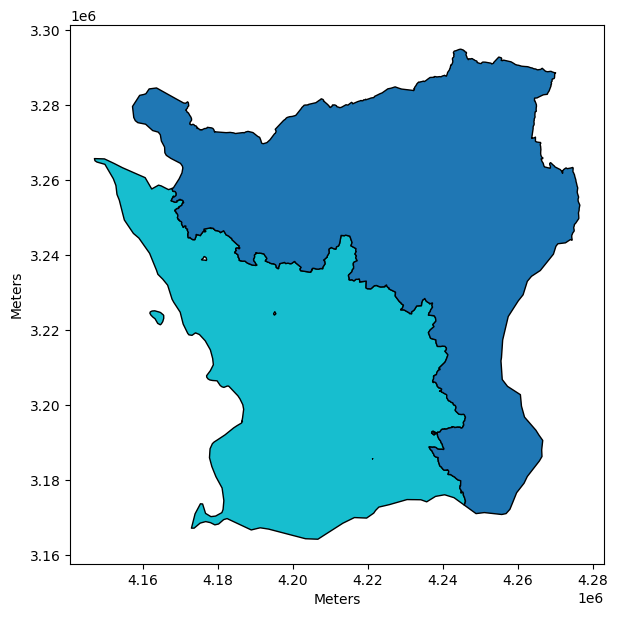

In [395]:
fig,ax = plt.subplots(figsize=(10,7))
SkaneMap.plot(ax=ax, column = "G_NAME", edgecolor='black', legend=False)
plt.xlabel('Meters')
plt.ylabel('Meters')
plt.show()

Our goal, now, it is to merge the databases (popSizeScania_rep and parishScaniaMap). To do so, first

In [384]:
# df1 = pd.DataFrame({'col_a':['one','two','three','four','five'], 'col_b':[1, 2, 3, 4, 5]})
# df2 = pd.DataFrame({'col_a':['one','too','three','fours','five'], 'col_b':['a','b','c','d','e']})
# print(df1)
# print(df2)
df1 = southeastParishes
df2 = parishScaniaMap

df_matches = fuzzy_match(
    df1,
    df2,
    'ParishName',
    'G_NAME',
    threshold=90,
    limit=1
)

df_output = df1.merge(
    df_matches,
    how='left',
    left_index=True,
    right_on='df_left_id'
).merge(
    df2,
    how='left',
    left_on='df_right_id',
    right_index=True,
    suffixes=['_df1', '_df2']
)

df_output.set_index('df_left_id', inplace=True)       # For some reason the first merge operation wrecks the dataframe's index. Recreated from the value we have in the matches lookup table

# df_output = df_output[['col_a_df1', 'col_b_df1', 'col_b_df2']]      # Drop columns used in the matching
# df_output.index.name = 'id'

In [442]:
southeastParishMap = df_output[[
    'Region', 'District(Härad)', 'ParishName', 'G_NAME', 'BeginPlaguePeriod', 'EndPlaguePeriod', 'VictimsNumber', 'geometry']]

index_list_delete = [59 # SKÖRUP
                     , 48 # JERRESTAD
                     ,14 # HÖGESTA
                     ,27 # HÖRUP PLAGUE CHECK LÖDERUP
                     ]
southeastParishMap.loc[southeastParishMap['ParishName'] == 'JERRESTAD']
southeastParishMap = southeastParishMap.drop(index_list_delete)

In [445]:
southeastParishMap

,Region,District(Härad),ParishName,G_NAME,BeginPlaguePeriod,EndPlaguePeriod,VictimsNumber,geometry
df_left_id,,,,,,,,
0,SOUTHEAST,ALBO,ANDRARUM,ANDRARUMS,NaN,NaN,NaN,"POLYGON ((4238250.249 3208074.003, 4238293.112..."
1,SOUTHEAST,ALBO,BRÖSARP,BRÖSARPS,NaN,NaN,NaN,"POLYGON ((4245792.553 3211743.504, 4246307.644..."
2,SOUTHEAST,ALBO,ELJARÖD,ELJARÖDS,JAN 1713,UNDEFINED,3,"POLYGON ((4244692.078 3203779.021, 4244526.296..."
3,SOUTHEAST,ALBO,FÅGELTOFTA,FÅGELTOFTA,NaN,NaN,NaN,"POLYGON ((4244692.078 3203779.021, 4244925.828..."
4,SOUTHEAST,ALBO,RAVLUNDA,RAVLUNDA,NaN,NaN,NaN,"POLYGON ((4248791.142 3204555.563, 4248848.683..."
5,SOUTHEAST,ALBO,RÖRUM,SÖDRA RÖRUMS,NaN,NaN,NaN,"POLYGON ((4219693.709 3227632.070, 4219625.094..."
6,SOUTHEAST,ALBO,SANKT OLOF,SANKT OLOFS,NaN,NaN,NaN,"POLYGON ((4251654.179 3201956.039, 4251734.798..."
7,SOUTHEAST,ALBO,SÖDRA MELLBY,SÖDRA MELLBY,OCT 1711,NOV 1711,3,"POLYGON ((4257537.206 3204129.443, 4257600.960..."
8,SOUTHEAST,ALBO,VITABY,VITABY,NaN,NaN,NaN,"POLYGON ((4257537.206 3204129.443, 4257371.054..."


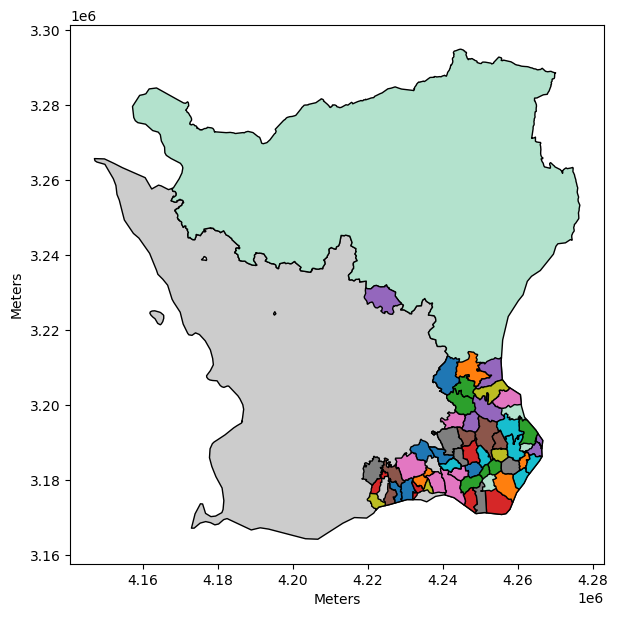

In [446]:
from shapely.geometry import Polygon
southeastScaniaMap = gpd.GeoDataFrame(southeastParishMap, geometry='geometry')

fig,ax = plt.subplots(figsize=(10,7))
SkaneMap.plot(ax=ax, column = "G_NAME", edgecolor='black', legend=False, cmap='Pastel2')
southeastScaniaMap.plot(ax=ax, column = "ParishName", edgecolor='black', legend=False)
plt.xlabel('Meters')
plt.ylabel('Meters')
plt.show()

In [364]:
parishPopPolygon = df_output[['LANGENNMN','GEOIDNMN', 'AR', 'BEF_TOT', 'BEF_GENTOT', 'G_NAME', 'GET_END_YE', 'geometry']]

In [368]:
# Export the DataFrame to a CSV file
parishPopPolygon.to_csv('parishPopPolygon.csv', encoding='utf-8', sep=';', index=False)


In [324]:
from thefuzz import process

df1 = pd.DataFrame({'Key':['Apple', 'Banana', 'Orange', 'Strawberry']})
df2 = pd.DataFrame({'Key':['Aple', 'Mango', 'Orag', 'Straw', 'Bannanna', 'Berry']})

def fuzzy_merge(df_1, df_2, key1, key2, threshold=90, limit=2):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_2[key2].tolist()
    
    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m
    
    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2
    
    return df_1


In [294]:

print(df1)
print(df2)
fuzzy_merge(df1, df2, 'Key', 'Key', threshold=90)


          Key
0       Apple
1      Banana
2      Orange
3  Strawberry
        Key
0      Aple
1     Mango
2      Orag
3     Straw
4  Bannanna
5     Berry


,Key,matches
0,Apple,
1,Banana,
2,Orange,
3,Strawberry,"Straw, Berry"


In [325]:
df = fuzzy_merge(popSizeScania_rep, parishScaniaMap, 'GEOIDNMN', 'G_NAME', threshold=90)

In [ ]:
df

In [251]:
popSizeScania_rep_names = get_Names(popSizeScania, 'GEOIDNMN').unique().tolist()
parishScaniaMap_names = get_Names(parishScaniaMap, 'G_NAME').unique().tolist()

set1 = set(popSizeScania_rep_names) # 403 different names
set2 = set(parishScaniaMap_names) # 411 different names

In [255]:
new_df = pd.merge(
    popSizeScania_rep, parishScaniaMap, left_on='GEOIDNMN', right_on='G_NAME')

In [260]:
def merge_df_condition(df1, df2, column_df1:str, column_df2:str, threshold):
    df1_name = get_Names(df1, column_df1).unique().tolist()
    df2_name = get_Names(df2, column_df2).unique().tolist()
    for i in range(len(df1)):
        name_df1_i = df1[column_df1].iloc[i]
        for j in range(len(df2)):
            name_df2_j = df2[column_df2].iloc[j]
            if is_similar(name_df1_i, name_df2_j, threshold) is True:
                
                df = pd.merge(df1, df2, left_on=column_df1, right_on=column_df2)
    return df

In [ ]:

merge_df_condition(popSizeScania_rep, parishScaniaMap, 'GEOIDNMN', 'G_NAME', 0.8)

In [209]:
def find_sim_names(data: pd.DataFrame, heading: str, name_list: list[str], threshold=0.8):
    sim_names_set = []
    for i in range(len(data)):
        name_i = data[heading].iloc[i]
        for name in name_list:
            if is_similar(name_i, name, threshold) is True:
               sim_names_set = sim_names_set + [{'name': name, 'name_i': name_i}]            
    return sim_names_set

In [218]:
find_sim_names(popSizeScania, 'GEOIDNMN', parishScaniaMap_names, 0.85)

[{'name': 'ONSLUNDA', 'name_i': 'ONSLUNDA'},
 {'name': 'HÄGLINGE', 'name_i': 'HÄGLINGE'},
 {'name': 'NORRA RÖRUMS', 'name_i': 'NORRA RÖRUM'},
 {'name': 'FÅGELTOFTA', 'name_i': 'FÅGELTOFTA'},
 {'name': 'RÖSTÅNGA', 'name_i': 'RÖSTÅNGA'},
 {'name': 'STENESTADS', 'name_i': 'STENESTAD'},
 {'name': 'RAVLUNDA', 'name_i': 'RAVLUNDA'},
 {'name': 'BRÖSARPS', 'name_i': 'BRÖSARP'},
 {'name': 'ANDRARUMS', 'name_i': 'ANDRARUM'},
 {'name': 'ELJARÖDS', 'name_i': 'ELJARÖD'},
 {'name': 'SÖDRA MELLBY', 'name_i': 'SÖDRA MELLBY'},
 {'name': 'VITABY', 'name_i': 'VITABY'},
 {'name': 'ÖSTRA VEMMERLÖVS', 'name_i': 'ÖSTRA VEMMERLÖV'},
 {'name': 'SIMRISHAMNS', 'name_i': 'SIMRISHAMN'},
 {'name': 'SIMRIS', 'name_i': 'SIMRIS'},
 {'name': 'ÖSTRA NÖBBELÖVS', 'name_i': 'ÖSTRA NÖBBELÖV'},
 {'name': 'GLADSAXS', 'name_i': 'GLADSAX'},
 {'name': 'ÖSTRA TOMMARPS', 'name_i': 'ÖSTRA TOMMARP'},
 {'name': 'VALLBY', 'name_i': 'VALLBY'},
 {'name': 'BOLSHÖGS', 'name_i': 'BOLSHÖG'},
 {'name': 'STIBY', 'name_i': 'STIBY'},
 {'name': 

In [178]:
def find_diff_names(data: pd.DataFrame, heading: str, name_list: list[str], threshold=0.8):
    diff_names_list = []
    for i in range(len(data)):
        name_i = data[heading].iloc[i]
        for name in name_list:
            if is_similar(name_i, name, threshold) is True:
                continue
            else:
                distancia_i = levenshtein_distance(name, name_i)
                diff_names_list = diff_names_list + [{'name': name, 'name_i': name_i, 'distance': distancia_i}] 
    return diff_names_list


In [ ]:
find_diff_names(popSizeScania, 'GEOIDNMN', parishesScania_names, 0.8)

In [189]:
from Levenshtein import distance as levenshtein_distance

def find_similar_names(data: pd.DataFrame, heading: str, name: str, threshold=0.8):
    aux_dict = {}
    for i in range(len(data)):
        name_i = data[heading].iloc[i]
        max_len_i = max(len(name), len(name_i))
        if max_len_i == 0:
            continue
        if (max_len_i - levenshtein_distance(name, name_i)) / max_len_i >= threshold:
            aux_dict[name_i] = {'distance': levenshtein_distance(name, name_i), 'position': i}
    final_positions = [value['position'] for key, value in aux_dict.items()]
    return data.iloc[final_positions]    
    

In [ ]:
find_similar_names(popSizeScania, 'GEOIDNMN', 'HELSINGBOR')

In [190]:
def filter_data_by_name(data: pd.DataFrame, heading: str, input_names: list[str]):
    output_names = []
    for name in input_names:
        filter_data = check_name(data, heading, name)
        if len(filter_data) == 0 :
            output_names  = output_names  + [name]
        else:
            continue
    return output_names

In [193]:
len(filter_data_by_name(popSizeScania, 'GEOIDNMN',parishScaniaMap_names ))

218

In [ ]:
#%%timeit
aux_dict = {}
parishMap = gpd.GeoDataFrame() 

for i in range(len(parishScaniaMap)):
    name_i = parishScaniaMap['G_NAME'].iloc[i]
    ar_i = parishScaniaMap['GET_END_YE'].iloc[i]
    if name_i in aux_dict:
        if ar_i < aux_dict[name_i]['min']:
            aux_dict[name_i] = {'min': ar_i, 'position': i}
    else:
        aux_dict[name_i] = {'min': ar_i, 'position': i}
final_positions = [value['position'] for key, value in aux_dict.items()]
parishMap = parishScaniaMap.iloc[final_positions]   
print(parishMap.shape)            
    

In [ ]:
parishMap['G_NAME'][parishMap['G_NAME'] == 'TRELLEBORGS']

In [ ]:
parishMap_names = get_Names(parishMap, 'G_NAME')

In [ ]:
filter_data_by_name(popSizeScania, 'GEOIDNMN', parishesScania_names)

In [ ]:
southeastParishesNoPop = []

for name in southeastParishes_names:
    filter_data = check_name(popSizeScania, popSizeScania['GEOIDNMN'], name)
    if len(filter_data) == 0 :
        southeastParishesNoPop = southeastParishesNoPop + [name]
    else:
        continue
    print(southeastParishesNoPop)
    

In [ ]:
filter_data_by_name(parishScaniaMap, parishScaniaMap['G_NAME'], popSizeScania_names)

In [ ]:
southeastParishesNoPop = []

for name in southeastParishes_names:
    filter_data = check_name(popSizeScania, popSizeScania['GEOIDNMN'], name)
    if len(filter_data) == 0 :
        southeastParishesNoPop = southeastParishesNoPop + [name]
    else:
        continue
    print(southeastParishesNoPop)
    

In [ ]:
southeastParishesNoPop = []

for name in southeastParishes_names:
    filter_data = check_name(popSizeScania, popSizeScania['GEOIDNMN'], name)
    if len(filter_data) == 0 :
        southeastParishesNoPop = southeastParishesNoPop + [name]
    else:
        continue
    #print(southeastParishesNoPop)
    

In [ ]:
southeastParishesNoPop = []

for name in southeastParishes_names:
    filter_data = check_name(popSizeScania, popSizeScania['GEOIDNMN'], name)
    if len(filter_data) == 0 :
        southeastParishesNoPop = southeastParishesNoPop + [name]
    else:
        continue
    #print(southeastParishesNoPop)
    

In [ ]:
southeastParishesNoPop = []

for name in southeastParishes_names:
    filter_data = check_name(popSizeScania, popSizeScania['GEOIDNMN'], name)
    if len(filter_data) == 0 :
        southeastParishesNoPop = southeastParishesNoPop + [name]
    else:
        continue
    #print(southeastParishesNoPop)
    

In [ ]:
southeastParishesNoPop = []

for name in southeastParishes_names:
    filter_data = check_name(popSizeScania, popSizeScania['GEOIDNMN'], name)
    if len(filter_data) == 0 :
        southeastParishesNoPop = southeastParishesNoPop + [name]
    else:
        continue
    #print(southeastParishesNoPop)
    

In [ ]:
southeastParishesNoPop = []

for name in southeastParishes_names:
    filter_data = check_name(popSizeScania, popSizeScania['GEOIDNMN'], name)
    if len(filter_data) == 0 :
        southeastParishesNoPop = southeastParishesNoPop + [name]
    else:
        continue
    #print(southeastParishesNoPop)
    

In [ ]:
southeastParishesNoPop = []

for name in southeastParishes_names:
    filter_data = check_name(popSizeScania, popSizeScania['GEOIDNMN'], name)
    if len(filter_data) == 0 :
        southeastParishesNoPop = southeastParishesNoPop + [name]
    else:
        continue
    #print(southeastParishesNoPop)
    

Check regular expressions code in Mathematica for eliminATING SOME STRINGS

In [ ]:

parishesScaniaNoPop = []

for name in parishesScania_names:
    filter_data = check_name(popSizeScania, popSizeScania['GEOIDNMN'], name)
    if len(filter_data) == 0 :
        parishesScaniaNoPop  = parishesScaniaNoPop  + [name]
    else:
        continue

    

In [ ]:
check_name(popSizeScania, popSizeScania['GEOIDNMN'], 'YSTAD')
check_name(popSizeScania, popSizeScania['GEOIDNMN'], 'OLOFS')


In [ ]:
type(censusScania['GEOIDNMN'])

In [ ]:
filt2 = popSizeScania['GEOIDNMN'].str.contains('NORRA RÖRUM', na=False)
#popSizeScania.loc[filt2]

In [ ]:
print(popSizeScania[['GEOIDNMN','AR']].iloc[2])